In [1]:
# prompt: check if we are using a gpu

import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
  print("No GPU available")


## Get data

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# prompt: check what files are in the pubmed_20k

!ls /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.zip


In [4]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [5]:
train_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'
test_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'
val_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'



In [6]:
# prompt: check all the filenames in the data_dir

tf.io.gfile.listdir(data_dir)


['train.txt', 'dev.txt', 'test.txt']

## Preprocess data
Time to become one with the data

In [7]:
# prompt: create function to read the lines of a document

def read_lines(path):
  with open(path, 'r') as f:
    lines = f.readlines()
  return lines

train_lines = read_lines(train_dir)
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
# Initialize variables
result_list = []
line_number = 0
doc_id = None

# Iterate through the data
for line in train_lines:
    line_number += 1

    # Split the line into parts based on tabs
    parts = line.strip().split('\t')

    # Check if the line has the expected format
    if len(parts) < 2:
        # Skip lines that don't have enough parts
        continue

    # Extract information
    if parts[0].startswith('###'):
        # This line contains the document ID
        doc_id = parts[0][3:]
    else:
        # Extract target and text
        target = parts[0]
        text = parts[1]


        # Create a dictionary for the current entry
        entry_dict = {'doc_id': doc_id, 'target': target, 'text': text, 'total_lines': len(parts)}

        # Append the dictionary to the list
        result_list.append(entry_dict)

# Print the result list
# for entry in result_list:
#     print(entry)


In [9]:
len(result_list)

180040

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = read_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

train_samples = preprocess_text_with_line_numbers(train_dir)
test_samples = preprocess_text_with_line_numbers(test_dir)
val_samples = preprocess_text_with_line_numbers(val_dir)

In [11]:
len(train_samples), len(test_samples), len(val_samples)

(180040, 30135, 30212)

In [ ]:
train_samples[:10]

In [13]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [31]:
# Distribution of labels in trainig data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

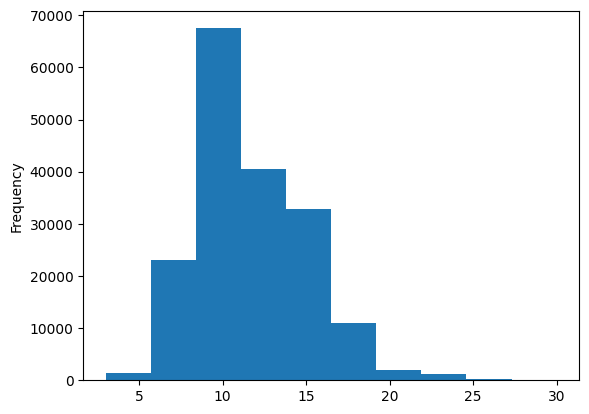

In [15]:
# Lets check the len of differente lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [19]:
# prompt: create train, val, and test sentences based on dataframes by converting them into a list

train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
len(train_sentences), len(val_sentences)

(180040, 30212)

In [17]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

<Axes: title={'center': 'Values in the target column'}, ylabel='Count'>

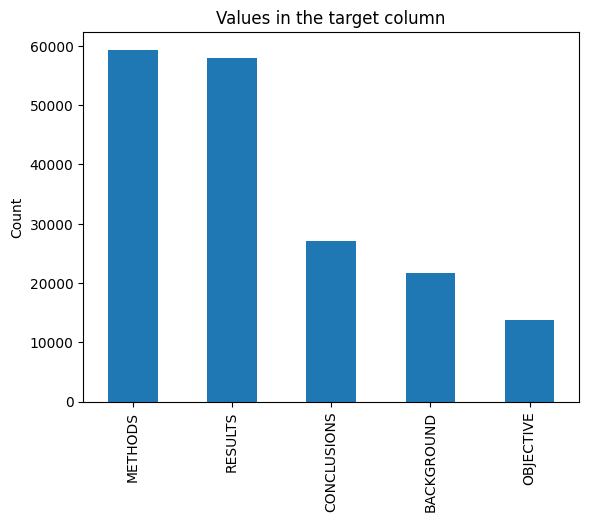

In [33]:
# prompt: create a bar chart that shows the number of values using value_counts for each value in  the column target in the train dataframe. This one has to show the total of values next to the bar in each target

train_df['target'].value_counts().plot.bar(title='Values in the target column', ylabel='Count')


## Make numberic labels

In [38]:
# prompt: use one hot encoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_train_labels = encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
encoded_val_labels = encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
encoded_test_labels = encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
encoded_train_labels, encoded_val_labels, encoded_test_labels

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]))

### Label encode labels

In [42]:
# prompt: # Extract labels ('target' columns) and encode them into integers with LabelEncoder

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoded_train_labels = label_encoder.fit_transform(train_df['target'].to_numpy())
label_encoded_val_labels = label_encoder.transform(val_df['target'].to_numpy())
label_encoded_test_labels = label_encoder.transform(test_df['target'].to_numpy())


label_encoded_train_labels[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [43]:
# Get class names and number of classes labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments

## Model 0: Baseline

In [ ]:
# prompt: create  baseline model using TfidVectorizer, MultinomialNB and Piepeline from sklearn\

# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline

# # Split data into train and test sets
# x_train, x_test, y_train, y_test = train_test_split(train_sentences, label_encoded_train_labels, test_size=0.2, random_state=42)

# # Create a TfidfVectorizer object
# vectorizer = TfidfVectorizer()

# # Create a MultinomialNB object
# classifier = MultinomialNB()

# # Create a pipeline object
# pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

# # Fit the pipeline to the training data
# pipeline.fit(x_train, y_train)

# # Make predictions on the test data
# y_pred = pipeline.predict(x_test)

# # Evaluate the model
# print('Accuracy:', accuracy_score(y_test, y_pred))
# print('F1 score:', f1_score(y_test, y_pred))


In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf_idf',TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=label_encoded_train_labels
            )



Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [46]:
model_0.score(X=val_sentences, y=label_encoded_val_labels)

0.7218323844829869

In [49]:
# prompt: make predictions using baseline model

baseline_preds = model_0.predict(X=val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [51]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, calculate_results


--2023-12-26 05:28:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-26 05:28:46 (114 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [53]:
calculate_results(baseline_preds,label_encoded_val_labels )

{'accuracy': 72.1832384482987,
 'precision': 0.7835634520695112,
 'recall': 0.7218323844829869,
 'f1': 0.7447397336209445}